# Aplicación de redes convolucionales a clasificación de especies

El objetivo de este notebook es crear una arquitectura capaz de clasificar flores de 102 categorías que provienen del dataset Oxford 102 disponible en la siguiente dirección:



In [ ]:
!curl https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  328M  100  328M    0     0  78.2M      0  0:00:04  0:00:04 --:--:-- 78.2M


In [ ]:
!git clone https://github.com/hfernandes1507/flower-classification-notebook.git

Cloning into 'flower-classification-notebook'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (26/26), done.


Primeramente vamos a importar las librerias que estaremos usando a lo largo del ejercicio.

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from torchvision import transforms, models
from torchvision import datasets, transforms
from PIL import Image

In [ ]:
data_dir = 'flower_data'
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

Ahora vamos a definir los image loaders necesarios para cargar el dataset. Tendremos:

- Un dataset de entrenamiento: Buscamos ampliar el dataset original con un mayor número de imágenes a través de transformaciones.
- Un datset de validación

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1)
    
    ax.grid('off')
    ax.imshow(image)
    
    return ax

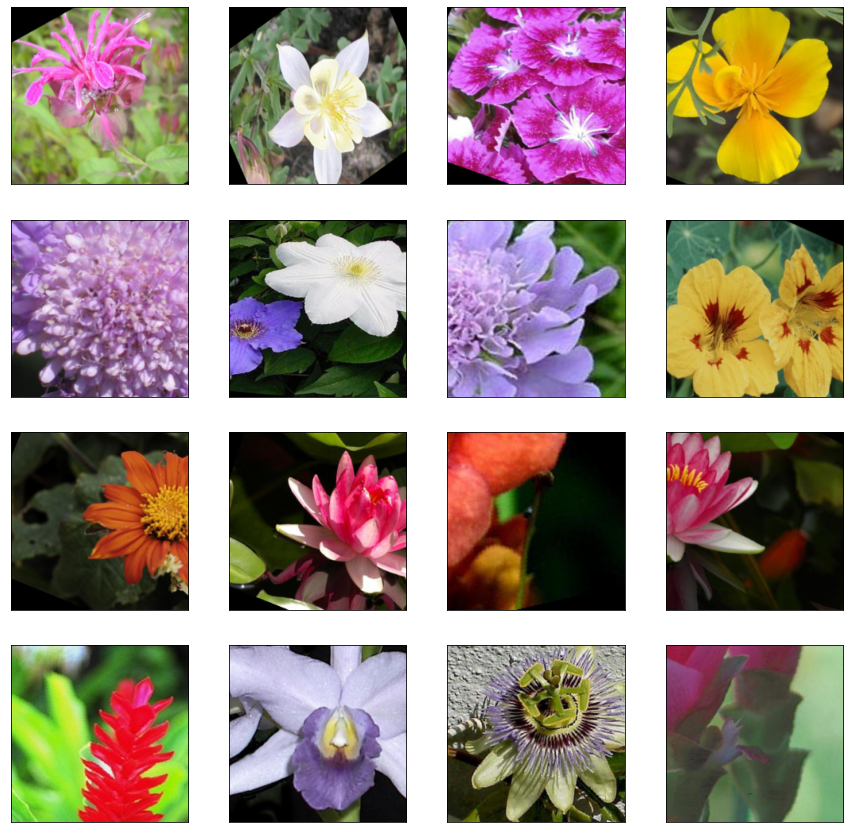

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(15, 15))
index = 0
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(4):
    for j in range(4):
        cell = ax[i][j]
        cell.set_xticks([])
        cell.set_yticks([])
        cell.grid(False)
        imshow(example_data[index], cell)
        index += 1
        
plt.show()

Ahora identificaremos todas las flores según el nombre de la categoría a la cual pertenecen.

In [ ]:
import json

with open('flower-classification-notebook/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print (sorted(list(cat_to_name)))

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


Esta es la definición de la clase FlowerClassifier que implementará nuestro clasificador de flores.

In [ ]:
class FlowerClassifier(nn.Module):
    def __init__(self):
        super(FlowerClassifier, self).__init__()
        self.fc1 = nn.Linear(2048, 1024, bias=True)
        self.fc2 = nn.Linear(1024, 102, bias=True)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        

Ahora declaramos la arquitectura de red convolucional a ser utilizada y también el dispositivo donde se realizará el entrenamiento.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = models.resnet152(pretrained=True)
model.fc = FlowerClassifier()

for param in model.parameters():
    param.requires_grad = True
    
model.to(device);

model

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Ahora definiremos la función de error y también el scheduler para regular la tasa de aprendizaje.

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

max_test_accuracy = 0

Evaluamos el modelo

In [ ]:
def evaluate(probs, labels, loader):
    _, top_class = torch.max(probs, dim=1)
                
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.sum(equals.type(torch.FloatTensor)).item()
    
    return accuracy / len(top_class)

Y luego, también creamos una función para guardar la mejor versión del mismo

In [ ]:
def checkpoint_model():
    checkpoint = {
              'model': model,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'scheduler_state_dict': scheduler.state_dict(),
              'criterion': criterion
    }

    torch.save(checkpoint, 'best_model.pth')

Ciclo principal de entrenamiento

In [ ]:
epochs = 5
train_loss = 0
print_every = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    steps = 0
    train_loss = 0
    train_accuracy = 0
    n_train_passes = 0
    
    scheduler.step()
    
    model.train()
    print("#### TURNING TO TRAINING MODE ####")
    
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model(inputs)
        
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += evaluate(logps, labels, train_loader)
        
        if steps % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {train_loss/n_train_passes:.3f}.. ")
            
        n_train_passes += 1
        
    print("Epoch " + str(epoch+1) + " Train loss {:.3f} ".format(train_loss/n_train_passes) + " train accuracy {:.3f}".format(train_accuracy * 100 / n_train_passes) + "%")
    train_losses.append(train_loss / n_train_passes)
        
    test_loss = 0
    test_accuracy = 0.0
    steps_test = 0
    n_test_passes = 0
    model.eval()
    
    print("#### TURNING TO EVALUATION MODE ####")
    
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            steps_test += 1
            
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            logps = model(val_inputs)
                
            batch_loss = criterion(logps, val_labels)
                
            test_loss += batch_loss.item()
            test_accuracy += evaluate(logps, val_labels, validation_loader)

            if steps_test % print_every == 0:    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      #f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/n_test_passes:.3f}.. ")
            
            
            running_loss = 0
            n_test_passes += 1
            
    test_accuracy = test_accuracy * 100 / n_test_passes
    
    if test_accuracy > max_test_accuracy:
        checkpoint_model()
        max_test_accuracy = test_accuracy
            
    print("Epoch " + str(epoch+1) + " Train loss {:.3f} ".format(test_loss/n_test_passes) + " val accuracy {:.3f}".format(test_accuracy) + "%")
    val_losses.append(test_loss / n_test_passes)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


#### TURNING TO TRAINING MODE ####
Epoch 1/5.. Train loss: 3.791.. 
Epoch 1/5.. Train loss: 3.069.. 
Epoch 1/5.. Train loss: 2.592.. 
Epoch 1/5.. Train loss: 2.254.. 
Epoch 1 Train loss 2.222  train accuracy 49.665%
#### TURNING TO EVALUATION MODE ####
Epoch 1 Train loss 0.505  val accuracy 86.138%
#### TURNING TO TRAINING MODE ####
Epoch 2/5.. Train loss: 0.911.. 
Epoch 2/5.. Train loss: 0.883.. 
Epoch 2/5.. Train loss: 0.836.. 
Epoch 2/5.. Train loss: 0.803.. 
Epoch 2 Train loss 0.799  train accuracy 79.543%
#### TURNING TO EVALUATION MODE ####
Epoch 2 Train loss 0.243  val accuracy 93.657%
#### TURNING TO TRAINING MODE ####
Epoch 3/5.. Train loss: 0.588.. 
Epoch 3/5.. Train loss: 0.596.. 
Epoch 3/5.. Train loss: 0.584.. 
Epoch 3/5.. Train loss: 0.573.. 
Epoch 3 Train loss 0.574  train accuracy 85.046%
#### TURNING TO EVALUATION MODE ####
Epoch 3 Train loss 0.249  val accuracy 93.056%
#### TURNING TO TRAINING MODE ####
Epoch 4/5.. Train loss: 0.471.. 
Epoch 4/5.. Train loss: 0.507.. 

Veamos algunas gráficas de evolución del error en entrenamiento y validación

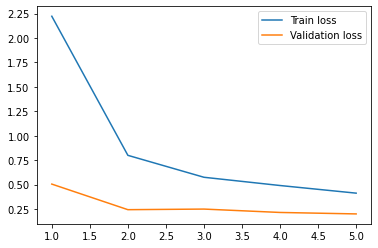

In [ ]:
epochs = np.linspace(1, len(val_losses), len(val_losses))

plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.legend()
plt.show()

Ahora vamos a evaluar el modelo con el dataset de testing. Asimismo creamos un archivo que nos permite visualizar la predicción de cada entrada y al final, también el accuracy obtenido con el dataset __test__

In [ ]:
import pandas as pd
import os

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        head, tail = os.path.split(path)
        tuple_with_path = (original_tuple + (tail,))
        return tuple_with_path


test_dataset = ImageFolderWithPaths(test_dir, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
file_dict = {}

def load_checkpoint_and_evaluate():
    file_dict = torch.load('best_model.pth')
  
    model = file_dict['model']
    model.eval()
    
    return model

model = load_checkpoint_and_evaluate()
model.class_to_idx = test_dataset.class_to_idx
counter = 0
accuracy = 0
failed = 0

predictions = []

class_to_idx = list(model.class_to_idx.items())
print(class_to_idx)

for inputs, labels, paths in test_loader:
    inputs, labels, paths = inputs.to(device), labels.to(device), paths
    probs = model(inputs)
    _, top_class = torch.max(probs, dim=1)
    
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.sum(equals.type(torch.FloatTensor)) / len(top_class)
    
    equals_numpy = equals.cpu().numpy()
    tc_numpy = top_class.cpu().numpy()
    labels_numpy = labels.view(*top_class.shape).cpu().numpy()
    
    predictions.append([paths[0], class_to_idx[tc_numpy[0]][0]])
    
    if (equals_numpy[0] == 0):
        failed += 1
        print("Error: Expected " + str(labels_numpy) + " but got " + str(tc_numpy))
        print("Log Probs: " + str(probs))
    
    counter += 1
    
    if counter % 200 == 0:
      print ("Accuracy on loading... {:.3f} %".format(accuracy * 100 / counter))
    
    del inputs, labels, paths

predictions = np.array(predictions)
    
df = pd.DataFrame({'file_name': predictions[:, 0], 'id': predictions[:, 1]})
df.to_csv('submission_102flowers.csv',index=False)
    
print ("Accuracy... {:.3f} %".format(accuracy * 100 / counter) + " total count: " + str(counter) + " failed: " + str(failed))

cuda
[('1', 0), ('10', 1), ('100', 2), ('101', 3), ('102', 4), ('11', 5), ('12', 6), ('13', 7), ('14', 8), ('15', 9), ('16', 10), ('17', 11), ('18', 12), ('19', 13), ('2', 14), ('20', 15), ('21', 16), ('22', 17), ('23', 18), ('24', 19), ('25', 20), ('26', 21), ('27', 22), ('28', 23), ('29', 24), ('3', 25), ('30', 26), ('31', 27), ('32', 28), ('33', 29), ('34', 30), ('35', 31), ('36', 32), ('37', 33), ('38', 34), ('39', 35), ('4', 36), ('40', 37), ('41', 38), ('42', 39), ('43', 40), ('44', 41), ('45', 42), ('46', 43), ('47', 44), ('48', 45), ('49', 46), ('5', 47), ('50', 48), ('51', 49), ('52', 50), ('53', 51), ('54', 52), ('55', 53), ('56', 54), ('57', 55), ('58', 56), ('59', 57), ('6', 58), ('60', 59), ('61', 60), ('62', 61), ('63', 62), ('64', 63), ('65', 64), ('66', 65), ('67', 66), ('68', 67), ('69', 68), ('7', 69), ('70', 70), ('71', 71), ('72', 72), ('73', 73), ('74', 74), ('75', 75), ('76', 76), ('77', 77), ('78', 78), ('79', 79), ('8', 80), ('80', 81), ('81', 82), ('82', 83), (

La siguiente función nos permite aplicar las mismas transformaciones del training a una nueva imagen que elegimos.

In [ ]:
def process_image(image):
    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    return test_transforms(image)
    

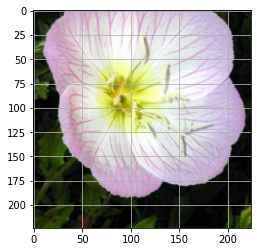

In [ ]:
imshow(process_image(Image.open('test/1/image_06743.jpg')))    

El método predict nos permite realizar predicciones sobre nuevos archivos de imágenes en nuestro sistema de archivos, y utiliza process_image para aplicar las transformaciones necesarias.

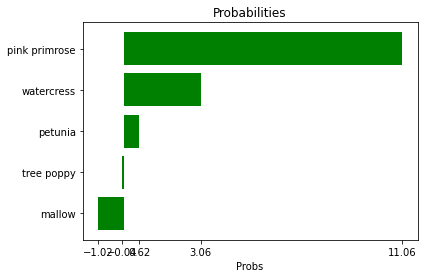

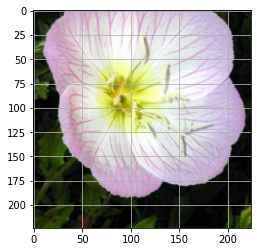

In [ ]:
def predict(image_path, model, topk=5):
    fig, ax = plt.subplots()
    
    image = Image.open(image_path)
    image = process_image(image)
    imshow(image)
    
    data = image.unsqueeze(0)
    probs = model(data.to(device))
    _, arg_max_probs = torch.topk(probs, topk)
    cat_indices = sorted(list(cat_to_name))
    
    cpu_probs = probs.detach().cpu().numpy()[0]
    cpu_argmax_probs = arg_max_probs.cpu().numpy()[0]
    labels = []
    
    class_to_idx = list(model.class_to_idx.items())
    
    for index in cpu_argmax_probs:
        labels.append(cat_to_name[class_to_idx[index][0]])
        
    yticks = np.arange(cpu_argmax_probs.shape[0])
      
    ax.barh(yticks, width=cpu_probs[cpu_argmax_probs], align='center',
        color='green', ecolor='black')
    ax.set_xticks(cpu_probs[cpu_argmax_probs])
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.array(labels))
    ax.invert_yaxis()
    ax.set_xlabel('Probs')
    ax.set_title('Probabilities')

    plt.show()
    del image
      
      
predict('test/1/image_06743.jpg', model)

¿Qué te pareció este ejercicio?
Esperamos que haya sido de tu entera satisfacción. Para mejorar el trabajo aquí realizado, te recomendamos lo siguiente:

- Intentar con un mayor número de iteraciones de entrenamiento de la red neuronal.
- Intentar con otra arquitectura pre-entrenada, por ejemplo VGG-16.
- Intentar con otra arquitectura del clasificador.
- Probar con tu propia arquitectura de red convolucional.

Si tienes cualquier inquietud, estaremos más que complacidos en poder asistirte.